## Preparando ambiente computacional

In [1]:
import numpy as np

# gerenciamento de arquivos
from funcoes.arquivos.load_data import load_data
from funcoes.arquivos.save_file import save_file

# plotar gráficos
from funcoes.plot_graficos.media_tempo import plotar_grafico
from funcoes.plot_graficos.analise_perfil import criar_tabela_perfil
from funcoes.plot_graficos.influence_plot import plot_influencia
from funcoes.plot_graficos.matriz_corr import matriz_correlacao

# criação dos modelos de regressão
from funcoes.modelo.modelo_log import modelo_log
from funcoes.modelo.modelo_polinomial import modelo_pol
from funcoes.modelo.modelo_sqrt import modelo_sqrt

# métrica r-quadrado (base de testes)
from funcoes.metrica_modelo.r2_modelo import r2_modelo

# avaliação de resíduos
from funcoes.residuos.indep_res import indep_res
from funcoes.residuos.padrao_lowess_res import residuos_lowess
from funcoes.residuos.media_mes_res import residuos_por_mes
from funcoes.residuos.normalidade_res import normal_res

# Outliers
from funcoes.outliers.remove_outliers import remove_outliers

# Multilinearidade
from funcoes.multicolinearidade.calculo_vif import calculate_vif

## Carregando a base de dados

* [Tratamento dos dados](./pr_tratamento.ipynb)
* [load_data](./funcoes/arquivos/load_data.py)

In [2]:
arquivo_train = './input_data/pr_train.feather'
data_train = load_data(arquivo_train)

arquivo_test = './input_data/pr_test.feather'
data_test = load_data(arquivo_test)

arquivo_train_dummies = './input_data/pr_train_dummies.feather'
data_train_dummies = load_data(arquivo_train_dummies)

arquivo_test_dummies = './input_data/pr_test_dummies.feather'
data_test_dummies = load_data(arquivo_test_dummies)

## Primeiro Modelo

* Avaliação do R²
* Parametrização do modelo logarítmo: [Modelo OLS](./funcoes/modelo/modelo_log.py)

Features: Idade, Tempo de Emprego, Posse de Imóvel, Posse de Véiculo, Sexo

In [3]:
model_log = modelo_log(df=data_train_dummies)

In [4]:
# salva em arquivos as métricas
sumario_log = str(model_log.summary())
save_file(sumario_log, './output/sumario_modelo_log.txt')

In [5]:
r_ajustado_log = np.round(model_log.rsquared_adj,2)
print(f"R² ajustado: {r_ajustado_log}")

R² ajustado: 0.43



## Análise de Perfil

* [Código - Tabela de Perfil](./funcoes/plot_graficos/analise_perfil.py)
* [Gráfico da média temporal](./funcoes/plot_graficos/media_tempo.py)

In [6]:
# inicia a tabela de perfil
tabela = criar_tabela_perfil(data_train)

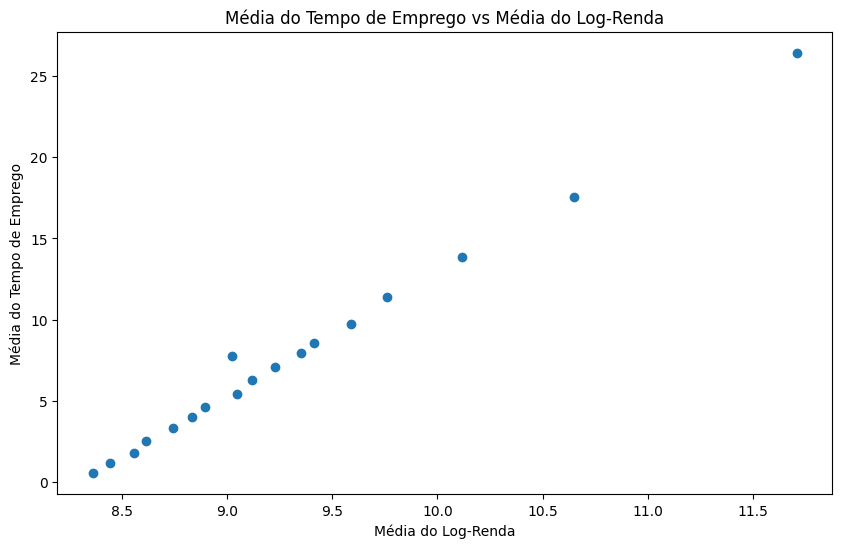

In [7]:
# cria o gráfico da média de temporal
plotar_grafico(tabela)

## Linearização

* Linearizando *tempo_emprego*: [Raiz Quadrada](./funcoes/modelo/modelo_sqrt.py) e [Polinomial](./funcoes/modelo/modelo_polinomial.py).

#### Raiz Quadrada

In [8]:
modelo_sqrt = modelo_sqrt(df_train=data_train_dummies)

In [9]:
# salva em arquivos as métricas
sumario_sqrt = str(modelo_sqrt.summary())
save_file(sumario_sqrt, './output/sumario_modelo_sqrt.txt')

In [10]:
r_ajustado_sqrt = np.round(modelo_sqrt.rsquared_adj,2)
print(f"R² ajustado: {r_ajustado_sqrt}")

R² ajustado: 0.15


#### Polinomial (ordem 3)

In [11]:
modelo_pol = modelo_pol(df=data_train_dummies)

In [12]:
# salva em arquivos as métricas
sumario_pol = str(modelo_pol.summary())
save_file(sumario_pol, './output/sumario_modelo_pol.txt')

In [13]:
r_ajustado_pol = np.round(modelo_pol.rsquared_adj,2)
print(f"R² ajustado: {r_ajustado_pol}")

R² ajustado: 0.4


## Avaliação na base de testes, R²
* [Avaliação dos modelos - R² na base de testes](./funcoes/metrica_modelo/r2_modelo.py)

#### Logarítmo

In [14]:
r2_log = r2_modelo(data_test_dummies, model_log)
save_file(r2_log, './output/rsquared_log.txt')

print(round(r2_log,2))

0.17


#### Raiz quadrada

In [15]:
r2_sqrt = r2_modelo(data_test_dummies, modelo_sqrt)
save_file(r2_sqrt, './output/rsquared_sqrt.txt')

print(round(r2_sqrt,2))

-1514396311.97


#### Conclusão

O modelo logarítmo simples, deveria ser o mais indicado. Pois a renda é uma distribuição assimétrica positiva. Isto é, possui muitos valores concentrados a esquerda e com poucos valores fora dessa concentração. Contudo, o modelo não performou de maneira adequada, indicando a necessidade de futuros ajustes.

Para a raiz quadrada, o modelo performa tão pessimamente que o R² é negativo. Indicando que o modelo é inválido para a situação.

É esperado que o modelo polinomial forneça o mesmo resultado do logarítmo, dado seus R² semelhante na base de testes.

## Suposições do Modelo

* [Independência dos resíduos](./funcoes/residuos/indep_res.py)


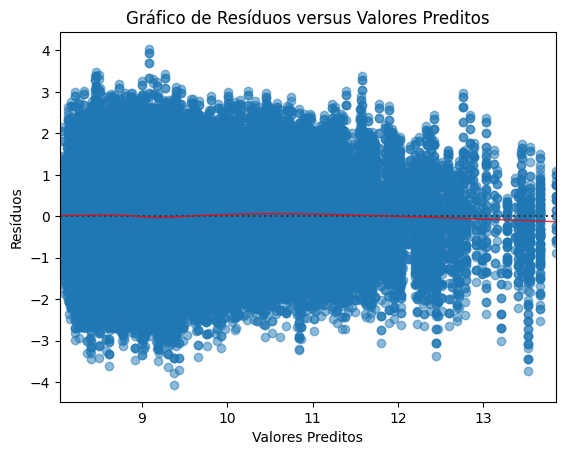

In [16]:
indep_res(df=data_train_dummies, modelo=model_log)

A curva lowess exibida pelo modelo logarítmico está próxima da região do zero. Pelo cálculo da média ponderada dos pontos vizinhos, os padrões locais são exibidas. Logo, é um indicativo que o modelo não exibe uma tendência significativa em nenhuma direção dos dados.

O gráfico mostra alguns pontos outliers que serão tratados.

#### Padrões dos resíduos

* [Padrão dos resíduos](./funcoes/residuos/padrao_lowess_res.py)

Variáveis: 
* posse de imóvel
* posse de véiculo 
* quantidade de filhos 
* quantidade de pessoas por residência 
* idade 
* tempo de emprego.

/home/jesse/.local/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


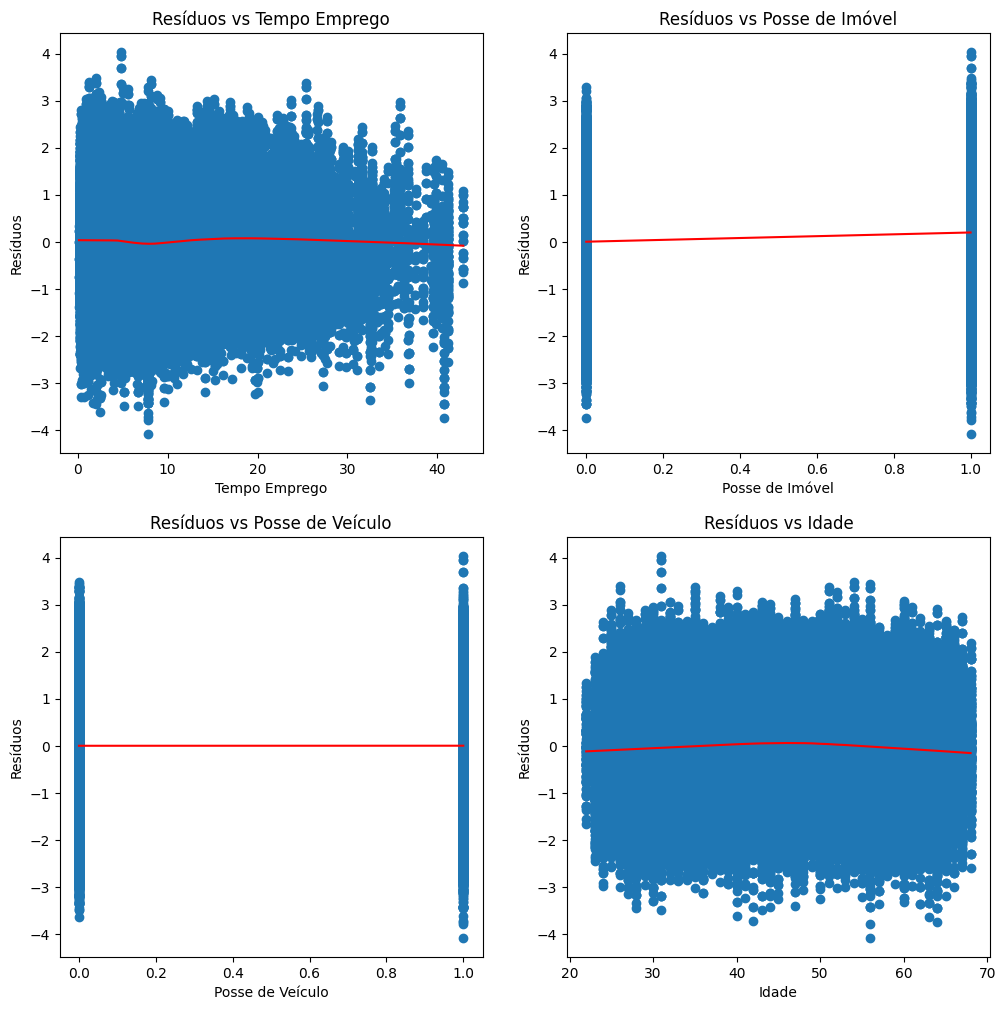

In [17]:
residuos_log = residuos_lowess(df=data_train_dummies, modelo=model_log)

A curva Lowess em torno do zero indica que não há padrões significativos para as variáveis utilizadas para ajustar o modelo.

Como visto anteriormente, outliers serão discutidos.

#### Compartamento da distribuição de resíduos
* [Comparando com a distribuição Normal](./funcoes/residuos/normalidade_res.py)

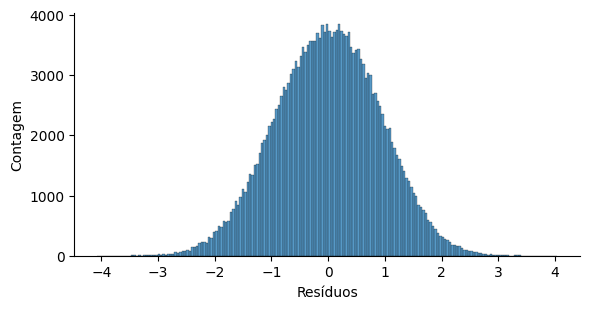

<Figure size 640x480 with 0 Axes>

In [18]:
# Calcula a distribuição dos resíduos para o modelo log
normal_res(residuos_log, 'modelo_log')

A curva de distribuição de resíduos se assemelha a Distribuição Normal.

#### Valor médio dos resíduos em função do mês
* [Média dos resíduos por mês](./funcoes/residuos/media_mes_res.py)

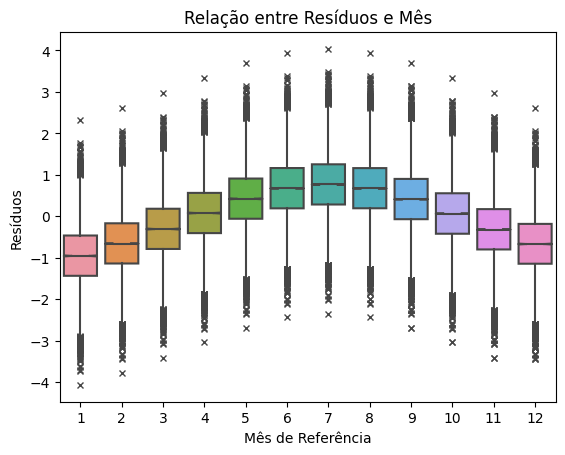

In [19]:
residuos_por_mes(df_original=data_train, 
                 df_dummie=data_train_dummies, 
                 residuos=residuos_log, 
                 modelo_tipo='modelo_log')

Como visto, a média dos resíduos não possui variação significativa em relação ao mês. A média fica entre [-1,1], que é aceitável. O padrão de outliers também se repete durante o ano.

#### Conclusão

As suposicões iniciais do modelo são atendidas.:
* Independência das variáveis
* Distribuição normal dos resíduos
* Homocedasticidade

Os outliers requerem tratamento, e será tópico da próxima sessão.

## Outliers

* [Gráfico de Studentized Resíduos](./funcoes/plot_graficos/influence_plot.py)
* [Remoção de Outliers](./funcoes/outliers/remove_outliers.py)

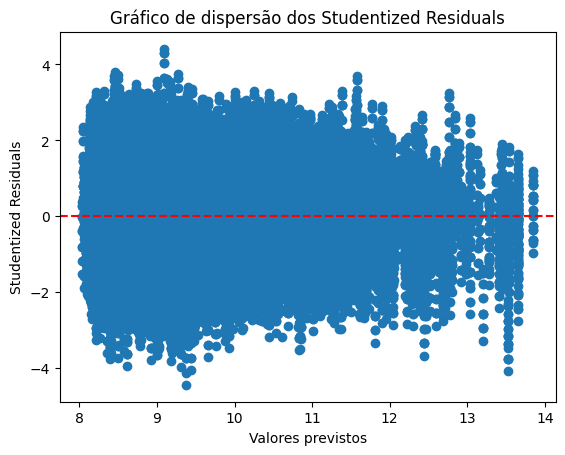

In [20]:
# Calculo dos residuos studentizados
std_residuos = plot_influencia(model_log)

* Parâmetro de corte: Std Resíduos = 1.8

Outras opções foram consideradas, esse número foi adequado por não perder muitos dados e por ficar próximo de 2.

In [21]:
df_train_dummies_no_outliers= remove_outliers(df=data_train_dummies, modelo=model_log)

Número de outliers: 14715


## Multicolinearidade

#### [Matriz de correlação de Spearman](./funcoes/plot_graficos/matriz_corr.py)


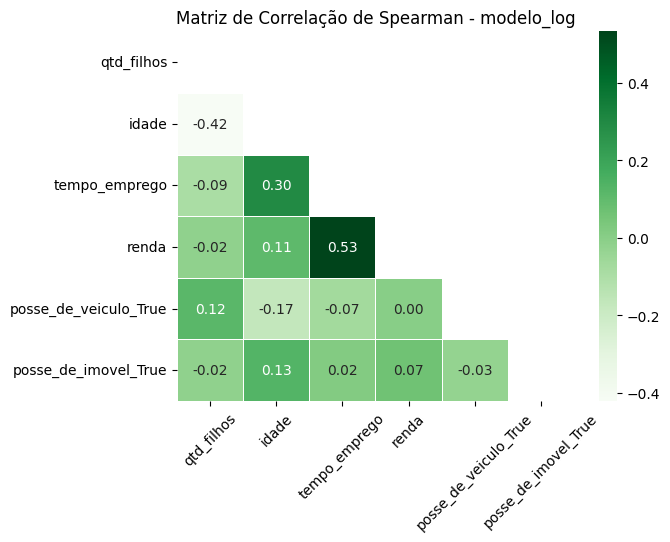

In [22]:
# Calculo matriz de correlação de spearman para o modelo log
matriz_correlacao(df=data_train_dummies, modelo='modelo_log')

#### [Cálculo do VIF (variance influence factor)](./funcoes/multicolinearidade/calculo_vif.py)

In [23]:
calculate_vif(data_train_dummies)

,Feature,VIF Factor
0,qtd_filhos,6.60
1,idade,19.20
2,tempo_emprego,4.81
3,qt_pessoas_residencia,33.83
4,renda,1.55
5,log_renda,49.49
6,Residuos,1.58


Os valores de VIF demonstram que existe baixa correlação entre as variáveis propostas pelo modelo de regressão. Logo, a modelagem tem mais chances de ser validada.

## Ajustes

Um possível ajuste seria considerar a base com a exclusão de outliers. Para isso, será avaliado o desempenho desse novo modelo na base de testes.

#### Modelo sem outliers

In [24]:
# modelo log sem outliers
model_log_sem_out = modelo_log(df_train_dummies_no_outliers)

# R² da base de treino
r_ajustado_log = np.round(model_log_sem_out.rsquared_adj,2)
print(f"R² ajustado: {r_ajustado_log}")

R² ajustado: 0.51


Houve um aumento de 0.43 para 0.51 com a remoção dos outliers.

#### R² na base de testes

In [25]:
r2_log_sem_outliers = r2_modelo(data_test_dummies, model_log_sem_out)

print(round(r2_log_sem_outliers,2))

0.17


Para a base de testes não houve mudanças. Logo, a remoção dos outliers não contribui para a efetividade do modelo.

## Conclusão Geral

Neste relatório, utilizamos a regressão linear como uma abordagem para prever a renda com base em um conjunto de variáveis independentes. Foi realizada uma análise exploratória dos dados, seguida de uma etapa de pré-processamento, que incluiu a remoção de outliers e a codificação das variáveis categóricas.

Após ajustar o modelo de regressão linear, identificamos que as variáveis "idade" e "tempo_emprego" são significativas para prever a renda, enquanto as demais apresentam uma influência limitada.

Contudo, é importante ressaltar que a regressão linear tem suas limitações e pressupostos, como a linearidade, independência dos erros e homocedasticidade. Essas limitações, apesar de levantadas e vizualizadas aqui, devem ser consideradas ao interpretar os resultados e tomar decisões com base nas previsões do modelo.

Por fim, a regressão linear foi uma boa abordagem inicial para a previsão de renda, fornecendo informações úteis sobre as variáveis mais importantes.